In [1]:
import os
import sys
sys.path.insert(0, os.path.relpath('../../../../../../'))

from importlib import reload
from functools import partial
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from recidiviz.calculator.modeling.population_projection.simulations.super_simulation_factory import SuperSimulationFactory
from recidiviz.calculator.modeling.population_projection.shell_compartment import ShellCompartment
from recidiviz.calculator.modeling.population_projection.spark_policy import SparkPolicy
from recidiviz.calculator.modeling.population_projection.compartment_transitions import CompartmentTransitions


In [2]:
test_sim = SuperSimulationFactory.build_super_simulation('../../state/IL/IL_prison_three_strikes_model_inputs.yaml')
# test_sim.simulate_baseline('pretrial', 'prison')

/Users/justine/.local/share/virtualenvs/pulse-data-xK3VhzVV/lib/python3.7/site-packages/google/cloud/bigquery/table.py:1728: UserWarning: A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.
  create_bqstorage_client=create_bqstorage_client,


outflows_data returned 216 results
transitions_data returned 130 results
total_population_data returned 0 results


In [3]:
policy_data = pd.read_csv('../../state/IL/preprocessed_policy_data_prison_three_strikes.csv')

In [4]:
races = ['white', 'non-white']
race_data = dict()
for race in races:
    race_data[race] = policy_data[policy_data.race == race]


initialization time:  30.222753763198853
simulation_time:  24.215599060058594
initialization time:  31.022413969039917
simulation_time:  24.274110078811646


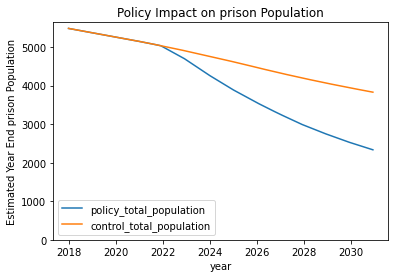

In [5]:
# Policy Option Methods
def remove_three_strikes(race, retroactive=False):
    return partial(CompartmentTransitions.use_alternate_transitions_data,
                   alternate_historical_transitions=race_data[race], 
                   retroactive=retroactive
                  )

policy_list_non_retroactive = [SparkPolicy(
            policy_fn=remove_three_strikes(race),
            spark_compartment='prison',
            sub_population={'race': race},
            apply_retroactive=False
            ) for race in races]
        
test_results = test_sim.simulate_policy(policy_list_non_retroactive, 'prison')

In [6]:
simulation_tag = 'IL_three_strikes'
test_sim.upload_simulation_results_to_bq('recidiviz-staging', simulation_tag)